In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


                     hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2004-12-31 01:00:00     1          4        4     12  2004        366   
2004-12-31 02:00:00     2          4        4     12  2004        366   
2004-12-31 03:00:00     3          4        4     12  2004        366   
2004-12-31 04:00:00     4          4        4     12  2004        366   
2004-12-31 05:00:00     5          4        4     12  2004        366   
...                   ...        ...      ...    ...   ...        ...   
2018-01-01 20:00:00    20          0        1      1  2018          1   
2018-01-01 21:00:00    21          0        1      1  2018          1   
2018-01-01 22:00:00    22          0        1      1  2018          1   
2018-01-01 23:00:00    23          0        1      1  2018          1   
2018-01-02 00:00:00     0          1        1      1  2018          2   

                     dayofmonth  weekofyear   AEP_

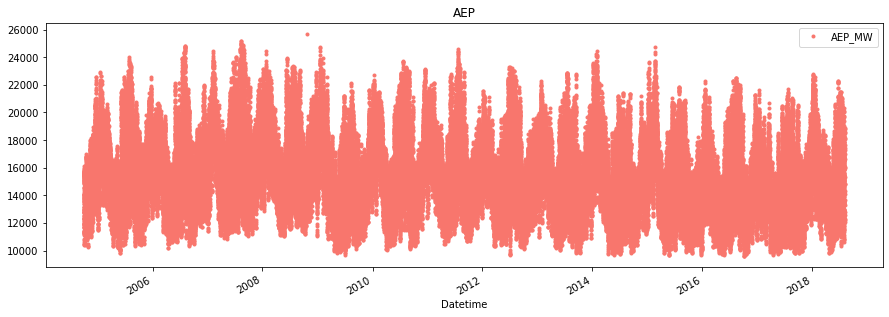

25695.0 9581.0


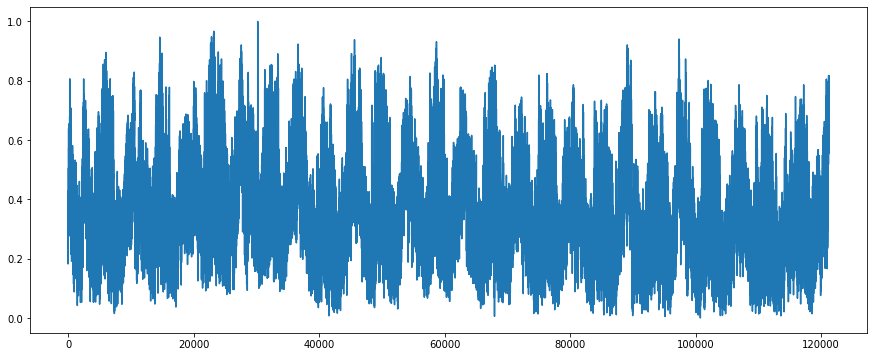

In [2]:
#Plotting hourly energy usage:

AEP = pd.read_csv('../input/hourly-energy-consumption/AEP_hourly.csv', index_col=[0], parse_dates=[0])

mau = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
bieudo = AEP.plot(style='.',figsize=(15,5), color=mau[0], title='AEP')
    
#Data transformation
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(AEP, label='AEP_MW')
features_and_target = pd.concat([X, y], axis=1)
print(features_and_target)
plt.show()

plt.figure(figsize=(15,6))
data_csv = AEP.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: (x-min_value) / scalar, dataset))
plt.plot(dataset)
print(max_value, min_value)

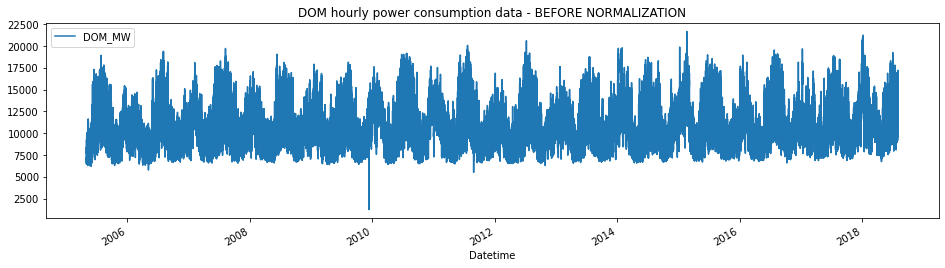

In [3]:
#choosing DOM_hourly.csv data for analysis
fpath='../input/hourly-energy-consumption/DOM_hourly.csv'

#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

#checking missing data
df.isna().sum()

#Data visualization

df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

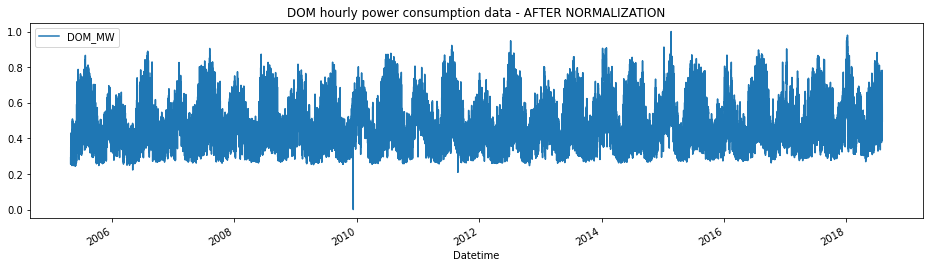

In [4]:
#Normalize DOM hourly power consumption data

def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

#Visualize data after normalization

df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [5]:
# train data for deep learning models

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i - seq_len: i, 0])
        y_train.append(stock.iloc[i, 0])

    # 1 last 6189 days are going to be used in test
    X_test = X_train[110000:]
    y_test = y_train[110000:]

    # 2 first 110000 days are going to be used in training
    X_train = X_train[:110000]
    y_train = y_train[:110000]

    # 3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # 4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]

In [6]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


In [7]:
#RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))
rnn_model.add(Dense(1))
rnn_model.summary()
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

2022-08-19 16:26:36.711350: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

2022-08-19 16:26:37.061384: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


110/110 [==============================] - 10s 73ms/step - loss: 0.0820
Epoch 2/10
110/110 [==============================] - 9s 81ms/step - loss: 0.0178
Epoch 3/10
110/110 [==============================] - 8s 74ms/step - loss: 0.0096
Epoch 4/10
110/110 [==============================] - 8s 73ms/step - loss: 0.0065
Epoch 5/10
110/110 [==============================] - 8s 74ms/step - loss: 0.0050
Epoch 6/10
110/110 [==============================] - 8s 73ms/step - loss: 0.0040
Epoch 7/10
110/110 [==============================] - 9s 81ms/step - loss: 0.0035
Epoch 8/10
110/110 [==============================] - 8s 73ms/step - loss: 0.0030
Epoch 9/10
110/110 [==============================] - 8s 74ms/step - loss: 0.0027
Epoch 10/10
110/110 [==============================] - 8s 75ms/step - loss: 0.0024


In [8]:
#r2 score for the values predicted by the above trained SIMPLE RNN model

rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9466957722475382


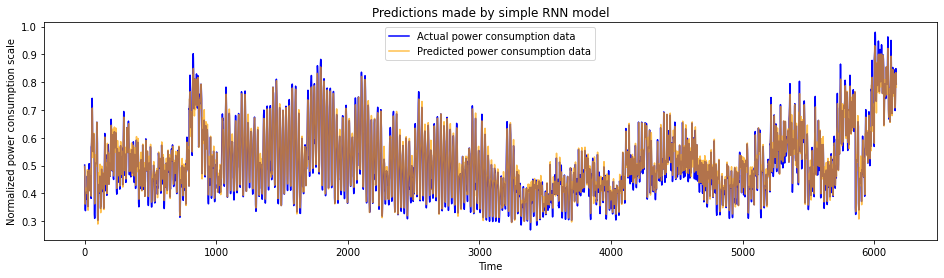

In [9]:
# compare the actual values vs predicted values by plotting a graph

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [10]:
#train model for LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 40)            6720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [11]:
#r2 score for the values predicted by the above trained LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.94996673239313


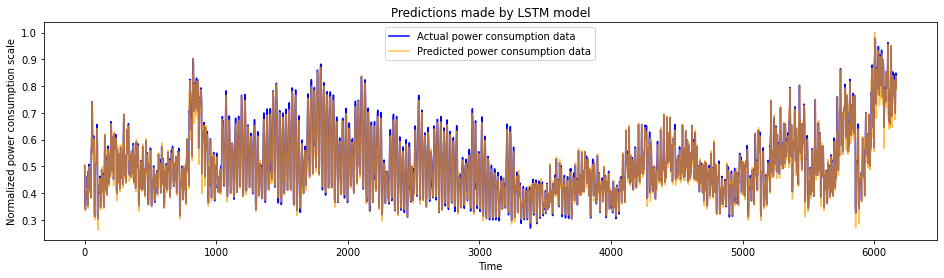

In [12]:
#actual values vs predicted values by plotting a graph
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

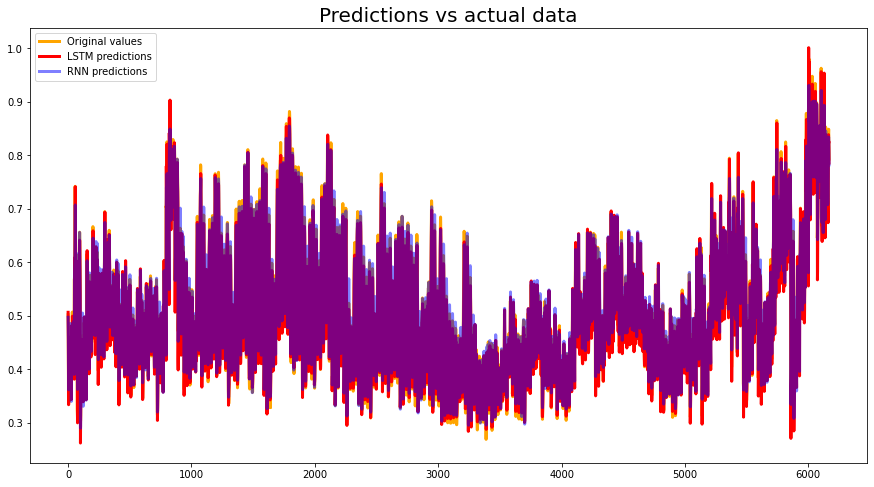

In [14]:
#RNN, LSTM model by plotting data in a single graph
plt.figure(figsize=(15,8))
plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="blue", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

In [ ]:
#GRU

In [87]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
train_data = pd.read_csv("../input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv",index_col=0)
# Display dimensions of dataframe
print(train_data.shape)
print(train_data.info())

(1462, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1+ KB
None


In [89]:
print("-----------------------------------------------------------------------")
print("Original dataset  : \n",train_data.sample(10)) 

-----------------------------------------------------------------------
Original dataset  : 
             meantemp  humidity  wind_speed  meanpressure
date                                                    
2014-04-07    27.250    47.625   12.962500   1009.625000
2014-12-16    17.750    72.375    7.425000   1017.375000
2015-02-25    23.125    58.625    6.500000   1008.500000
2014-06-30    32.000    67.750    3.250000    997.500000
2013-12-21    14.750    94.000    0.462500   1017.000000
2015-01-30    12.750    56.125   12.037500   1020.375000
2015-02-02    17.375    63.875   11.812500   1017.500000
2015-04-20    32.875    37.875    7.187500   1005.750000
2014-02-12    13.250    67.000    9.262500   1013.500000
2016-05-22    36.800    44.800    6.553333    996.466667


In [90]:
print("-----------------------------------------------------------------------")
# Display statistics for numeric columns
print(train_data.describe())

-----------------------------------------------------------------------
          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333


-----------------------------------------------------------------------


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

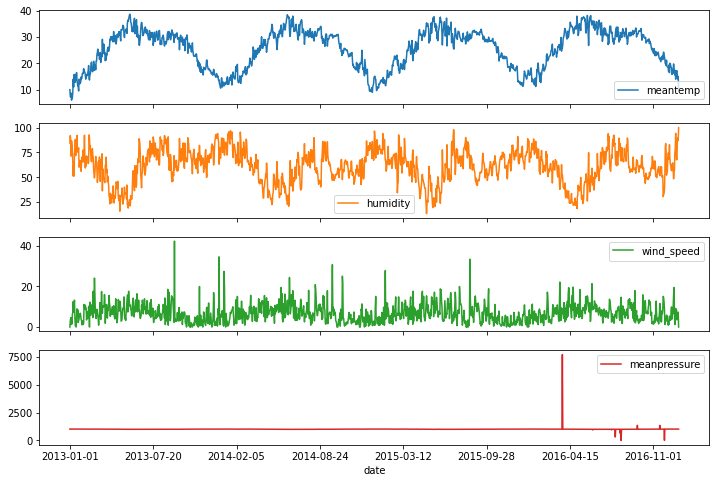

In [91]:
print("-----------------------------------------------------------------------") 
train_data.plot(figsize=(12,8),subplots=True)

array([[<AxesSubplot:title={'center':'meantemp'}>,
        <AxesSubplot:title={'center':'humidity'}>],
       [<AxesSubplot:title={'center':'wind_speed'}>,
        <AxesSubplot:title={'center':'meanpressure'}>]], dtype=object)

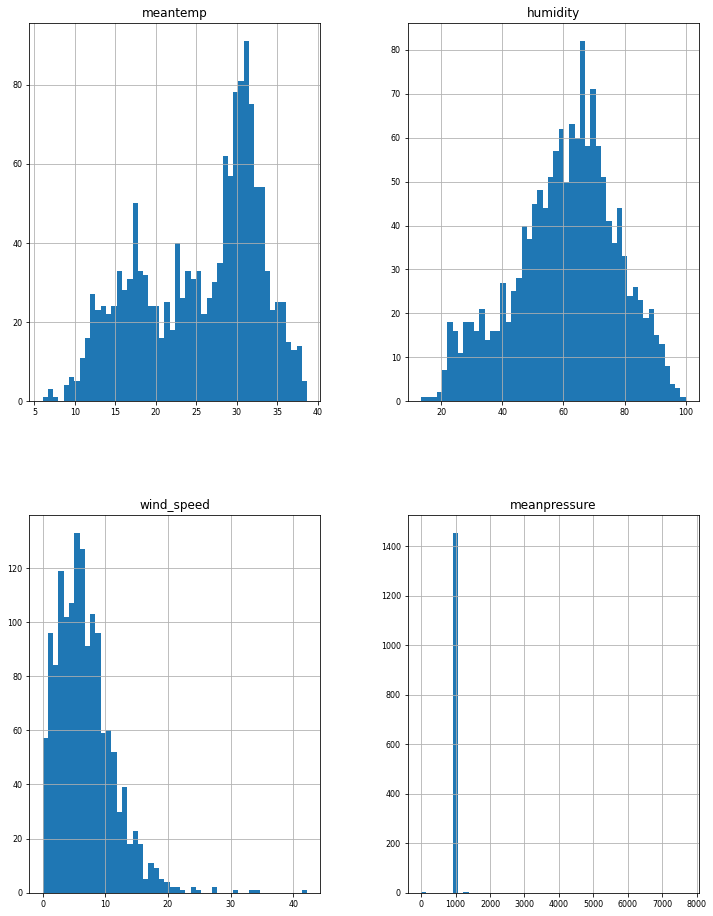

In [92]:
# Now lets plot them all
train_data.hist(figsize=(12, 16), bins=50, xlabelsize=8, ylabelsize=8)

null values : 
 meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


<AxesSubplot:ylabel='date'>

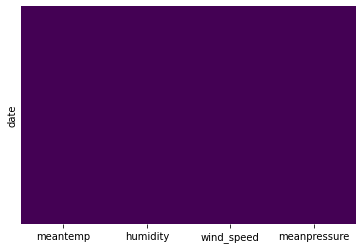

In [93]:
# To check Missing Values 
print("null values : \n",train_data.isnull().sum()) 
sns.heatmap(train_data.isnull(), cbar=False, yticklabels=False, cmap="viridis")

In [94]:
# We choose a specific feature (features). In this example,
my_dataset = train_data[["meantemp",'humidity','wind_speed','meanpressure']]


print("Our new dataset : \n",my_dataset.sample(5))

Our new dataset : 
              meantemp   humidity  wind_speed  meanpressure
date                                                      
2014-10-11  25.714286  57.142857    6.937500   1008.250000
2016-12-17  17.500000  63.388889    6.731579   1016.947368
2014-04-06  30.125000  45.250000    6.712500   1007.500000
2015-12-07  17.625000  76.875000    2.312500   1017.250000
2015-04-26  28.750000  51.125000   15.737500   1008.000000


In [95]:
print("-----------------------------------------------------------------------")
# ensure all data is float
my_dataset = my_dataset.astype("float32")
values     = my_dataset.values
print("values : \n",values)

-----------------------------------------------------------------------
values : 
 [[  10.          84.5          0.        1015.6667   ]
 [   7.4         92.           2.98      1017.8      ]
 [   7.1666665   87.           4.633333  1018.6667   ]
 ...
 [  14.095238    89.666664     6.266667  1017.9048   ]
 [  15.052631    87.           7.325     1016.1      ]
 [  10.         100.           0.        1016.       ]]


In [96]:
print("-----------------------------------------------------------------------")
# normalize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print("scaled : \n",scaled)

-----------------------------------------------------------------------
scaled : 
 [[0.12227073 0.8209571  0.         0.1326033 ]
 [0.04279476 0.9075908  0.07058267 0.13288099]
 [0.03566229 0.849835   0.10974261 0.1329938 ]
 ...
 [0.24745268 0.88063806 0.14842887 0.13289464]
 [0.276718   0.849835   0.17349596 0.1326597 ]
 [0.12227073 1.0000001  0.         0.1326467 ]]


In [97]:
values.shape

(1462, 4)

In [98]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
              names += [("var%d(t)" % (j+1)) for j in range(n_vars)]
        else:
              names += [("var%d(t+%d)" % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# ******************************************************************************

In [99]:
# frame as supervised learning
# reshape into X=t and Y=t+1
i_in  = 100 # past observations
n_out = 1 # future observations
reframed = series_to_supervised(scaled, i_in, n_out)
print("Represent the dataset as a supervised learning problem : \n",reframed.head(10))
print("-----------------------------------------------------------------------")

Represent the dataset as a supervised learning problem : 
      var1(t-100)  var2(t-100)  var3(t-100)  var4(t-100)  var1(t-99)  \
100     0.122271     0.820957     0.000000     0.132603    0.042795   
101     0.042795     0.907591     0.070583     0.132881    0.035662   
102     0.035662     0.849835     0.109743     0.132994    0.081514   
103     0.081514     0.668867     0.029212     0.132799    0.000000   
104     0.000000     0.847910     0.087636     0.132712    0.030568   
105     0.030568     0.801320     0.035054     0.132907    0.030568   
106     0.030568     0.752805     0.149218     0.133167    0.087336   
107     0.087336     0.580858     0.169182     0.133000    0.244541   
108     0.244541     0.436881     0.296068     0.132777    0.152838   
109     0.152838     0.561056     0.175272     0.132603    0.296943   

     var2(t-99)  var3(t-99)  var4(t-99)  var1(t-98)  var2(t-98)  ...  \
100    0.907591    0.070583    0.132881    0.035662    0.849835  ...   
101    0.849835

In [100]:
# split into train and test sets
# convert an array of values into a dataset matrix
values_spl = reframed.values
train_size = int(len(values_spl) * 0.80)
test_size  = len(values_spl) - train_size
train, test = values_spl[0:train_size,:], values_spl[train_size:len(values_spl),:]
print("len train and test : ",len(train), "  ", len(test))

len train and test :  1089    273


In [101]:
print("-----------------------------------------------------------------------")
# split into input and outputs
X_train, y_train = train[:, :-4], train[:, -4:]
X_test, y_test   = test[:, :-4],  test[:, -4:]

print("X_train shape : ",X_train.shape," y_train shape : ",y_train.shape)
print("X_test shape  : ",X_test.shape, " y_test shape  : ",y_test.shape)

-----------------------------------------------------------------------
X_train shape :  (1089, 400)  y_train shape :  (1089, 4)
X_test shape  :  (273, 400)  y_test shape  :  (273, 4)


In [102]:
print("-----------------------------------------------------------------------")
# reshape input to be 3D [samples, timesteps, features]
# The LSTM network expects the input data (X) to be provided with 
# a specific array structure in the form of: [samples, time steps, features].
# Currently, our data is in the form: [samples, features] 
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("X_train shape 3D : ",X_train.shape," y_train shape : ",y_train.shape)
print("X_test shape  3D : ",X_test.shape, " y_test shape  : ",y_test.shape)

-----------------------------------------------------------------------
X_train shape 3D :  (1089, 1, 400)  y_train shape :  (1089, 4)
X_test shape  3D :  (273, 1, 400)  y_test shape  :  (273, 4)


In [103]:
#import and define the layers
model = keras.models.Sequential()
model.add(keras.layers.GRU(64, return_sequences=True, activation="relu", 
            kernel_initializer="he_normal", recurrent_initializer="he_normal", 
            dropout=0.15, recurrent_dropout=0.15,
						input_shape=(X_train.shape[1], X_train.shape[2]) ))
model.add(keras.layers.GRU(32,return_sequences=True, activation="relu", kernel_initializer="he_normal", 
            recurrent_initializer="he_normal", dropout=0.15, recurrent_dropout=0.15 ))
model.add(keras.layers.GRU(8, activation="relu", kernel_initializer="he_normal", 
            recurrent_initializer="he_normal", dropout=0.15, recurrent_dropout=0.15 ))
model.add(keras.layers.Dense(4, activation="relu"))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 1, 64)             89472     
_________________________________________________________________
gru_7 (GRU)                  (None, 1, 32)             9408      
_________________________________________________________________
gru_8 (GRU)                  (None, 8)                 1008      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
Total params: 99,924
Trainable params: 99,924
Non-trainable params: 0
_________________________________________________________________
None


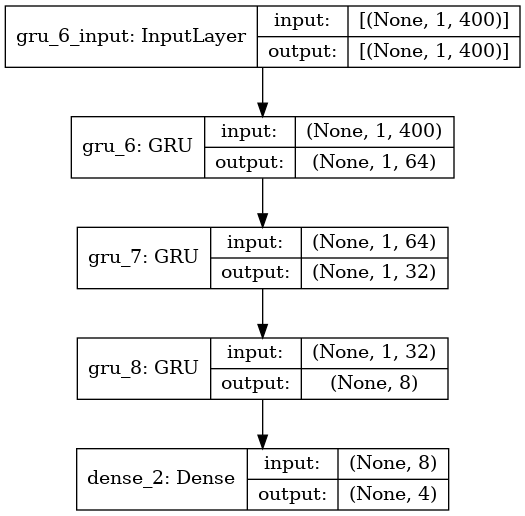

In [104]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [105]:
# Compiling the model
optimizer = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mse","mae"])

# Learning rate scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.00001, patience=3,
                                      monitor="val_loss", min_lr=0.00000001)

In [106]:
# Training and evaluating the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[lr_scheduler])

Epoch 1/100
14/14 [==============================] - 10s 88ms/step - loss: 0.1164 - mse: 0.1164 - mae: 0.2643 - val_loss: 0.0367 - val_mse: 0.0367 - val_mae: 0.1475
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0437 - mse: 0.0437 - mae: 0.1532 - val_loss: 0.0142 - val_mse: 0.0142 - val_mae: 0.0913
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0236 - mse: 0.0236 - mae: 0.1087 - val_loss: 0.0135 - val_mse: 0.0135 - val_mae: 0.0789
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.0962 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0789
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0906 - val_loss: 0.0102 - val_mse: 0.0102 - val_mae: 0.0691
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0850 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0640
Epoch 7/100
14/

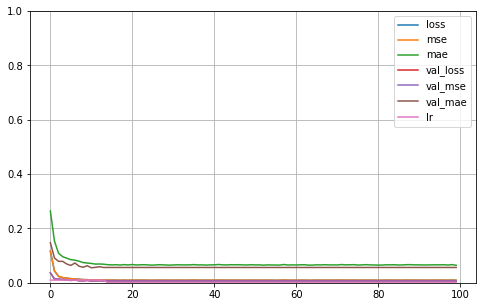

In [107]:
# plot the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()



In [108]:
print("-----------------------------------------------------------------------")
# Evaluate the model
model_evaluate = model.evaluate(X_test, y_test)
print("Loss                   : ",model_evaluate[0])
print("Mean Squared Error     : ",model_evaluate[1])
print("Mean Absolute Error    : ",model_evaluate[2])  


-----------------------------------------------------------------------
9/9 [==============================] - 0s 3ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0652
Loss                   :  0.008361274376511574
Mean Squared Error     :  0.008361274376511574
Mean Absolute Error    :  0.06517541408538818


In [109]:
# make predictions
trainPredict = model.predict(X_train)
testPredict  = model.predict(X_test)
print("trainPredict : ",trainPredict.shape)
print("testPredict  : ",testPredict.shape)


trainPredict :  (1089, 4)
testPredict  :  (273, 4)


In [110]:
print(trainPredict)

array([[0.794252  , 0.29386416, 0.16390276, 0.13381857],
       [0.80810547, 0.28626317, 0.16907552, 0.1337166 ],
       [0.8088531 , 0.28755552, 0.1696803 , 0.13367665],
       ...,
       [0.67830986, 0.43075496, 0.139501  , 0.13334922],
       [0.69778967, 0.4183182 , 0.14170927, 0.13308588],
       [0.7168243 , 0.40688953, 0.14848372, 0.13296095]], dtype=float32)

In [111]:
testPredict = scaler.inverse_transform(testPredict)

In [112]:
print(testPredict.shape) 
print(y_test.shape)

(273, 4)
(273, 4)


In [113]:
y_test=scaler.inverse_transform(y_test)

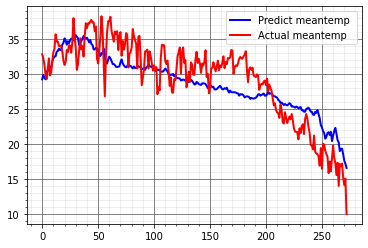

In [114]:
#plot for meantemp

plt.plot(testPredict[:,0], color="blue", 
         label="Predict meantemp ", linewidth=2)

plt.plot(y_test[:,0], color="red", 
         label="Actual meantemp ", linewidth=2)

plt.legend()
# Show the major grid lines with dark grey lines
plt.grid(visible=True, which="major", color="#666666", linestyle="-")
# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(visible=True, which="minor", color="#999999", linestyle="-", alpha=0.2)

plt.show()




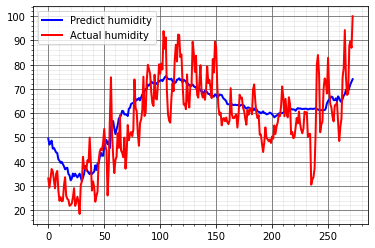

In [115]:
#plot for humidity

plt.plot(testPredict[:,1], color="blue", 
         label="Predict humidity", linewidth=2)
plt.plot(y_test[:,1], color="red", 
         label="Actual humidity", linewidth=2)
plt.legend()

# Show the major grid lines with dark grey lines
plt.grid(visible=True, which="major", color="#666666", linestyle="-")
# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(visible=True, which="minor", color="#999999", linestyle="-", alpha=0.2)
plt.show()

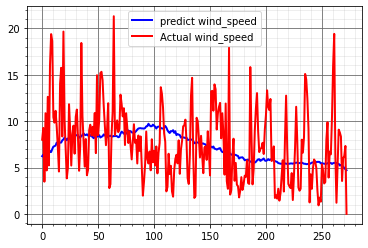

In [116]:
#plot for windspeed

plt.plot(testPredict[:,2], color="blue", 
         label="predict wind_speed", linewidth=2)
plt.plot(y_test[:,2], color="red", 
         label="Actual wind_speed", linewidth=2)
plt.legend()

# Show the major grid lines with dark grey lines
plt.grid(visible=True, which="major", color="#666666", linestyle="-")
# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(visible=True, which="minor", color="#999999", linestyle="-", alpha=0.2)

plt.show()

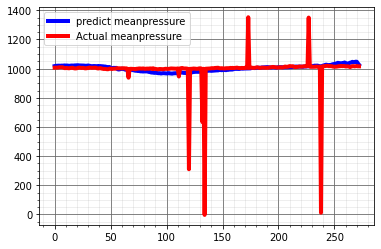

In [117]:
#plot for meanpressure

plt.plot(testPredict[:,3], color="blue", 
         label="predict meanpressure", linewidth=4)
plt.plot(y_test[:,3], color="red", 
         label="Actual meanpressure", linewidth=4)

plt.legend()

# Show the major grid lines with dark grey lines
plt.grid(visible=True, which="major", color="#666666", linestyle="-")
# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(visible=True, which="minor", color="#999999", linestyle="-", alpha=0.2)

plt.show()

In [ ]:
# Neural Prophet

In [2]:
import pandas as pd 
from neuralprophet import NeuralProphet

In [31]:
#read and pre-process the data
df_np = pd.read_csv("DailyDelhiClimateTrain.csv", parse_dates=["date"]) 
df_np = df_np[["date", "meantemp"]] 
df_np.rename(columns={"date": "ds", "meantemp": "y"}, inplace=True)

In [32]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(
    growth="linear",  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=0,
    d_hidden=None,     # Dimension of hidden layers of AR-Net
    learning_rate=None,
    epochs=40,
    loss_func="Huber",
    normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True,
)

In [34]:
#make predictions
metrics = model.fit(df_np, freq="D") 
future = model.make_future_dataframe(df_np, periods=365, n_historic_predictions=len(df_np)) 
forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/129 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.14E-01, min: 1.54E-01


  0%|          | 0/129 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.14E-01, min: 1.54E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.37E-01
Epoch[40/40]: 100%|███████████████| 40/40 [00:04<00:00,  9.95it/s, SmoothL1Loss=0.00238, MAE=1.6, RMSE=2.02, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\ashwi\anaconda3\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major fre

Text(0.5, 1.0, 'Mean Temperature in Delhi')

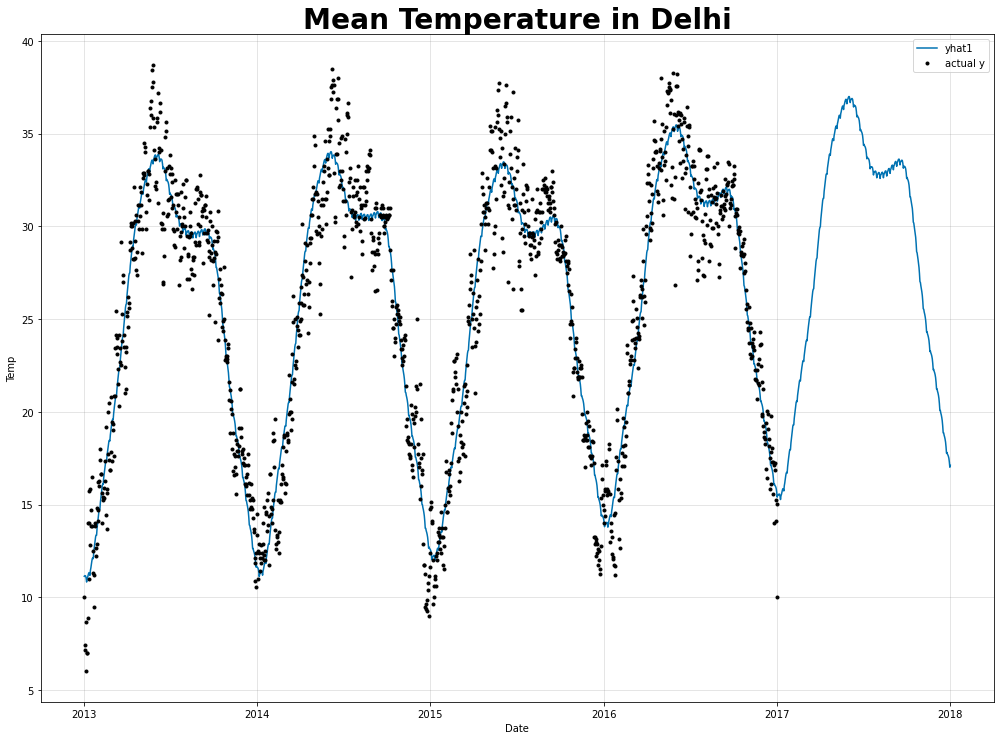

In [35]:
import matplotlib.pyplot as plt 
#forecast plot
fig, ax = plt.subplots(figsize=(14, 10)) 
model.plot(forecast, xlabel="Date", ylabel="Temp", ax=ax)
ax.set_title("Mean Temperature in Delhi", fontsize=28, fontweight="bold")

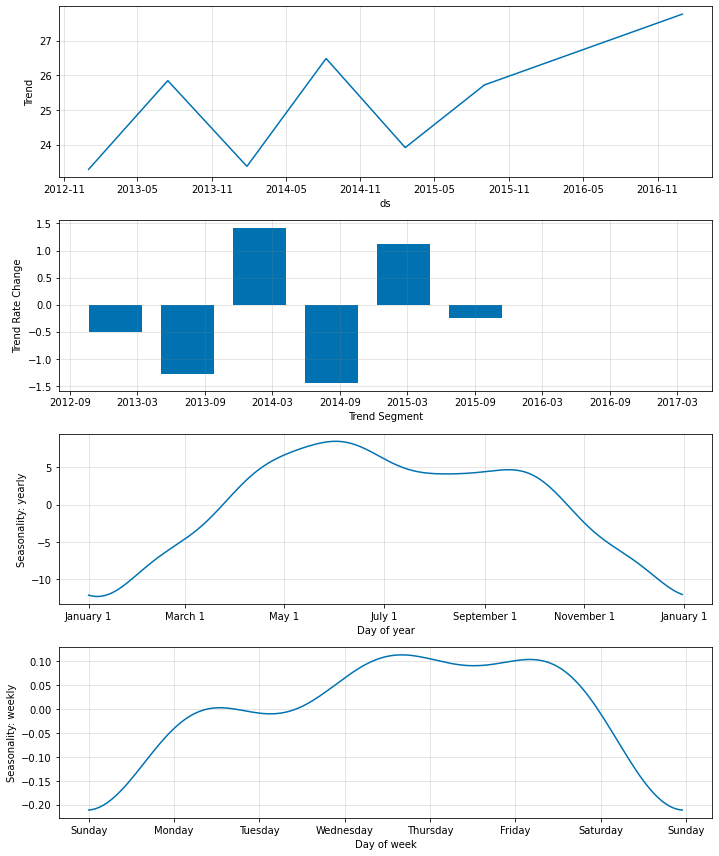

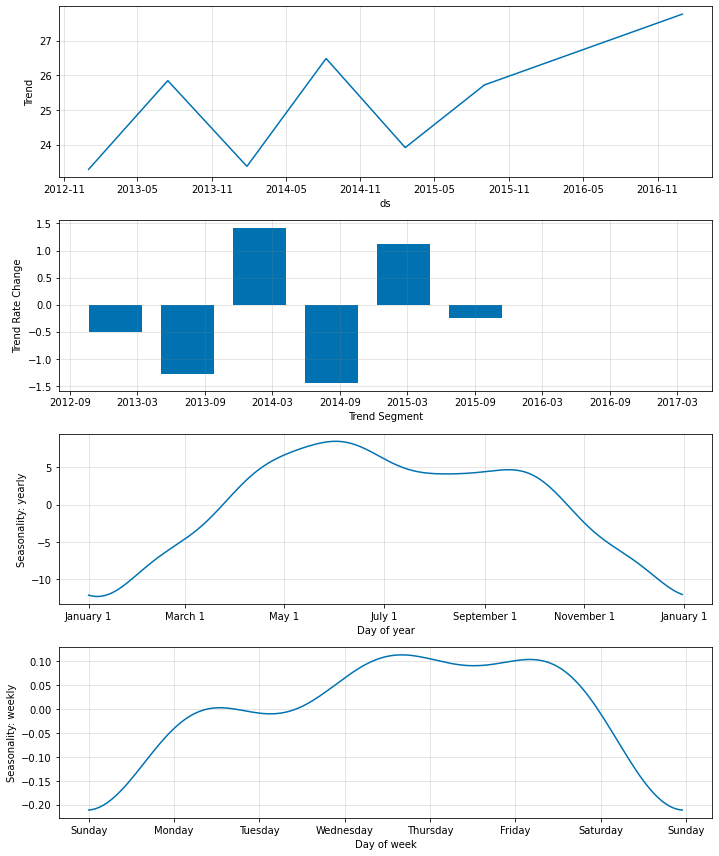

In [39]:
#plotting model parameters
model.plot_parameters()

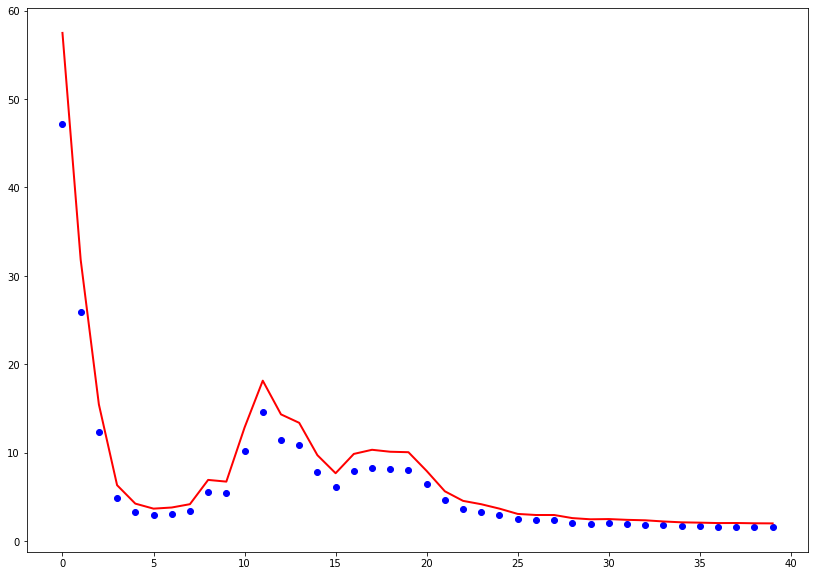

In [38]:
#ploting Evaluation
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MAE"], 'ob', linewidth=6)  
ax.plot(metrics["RMSE"], '-r', linewidth=2)